read_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import cv2
from sklearn.model_selection import StratifiedKFold

from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda,MaxPooling2D,Flatten,Input,Attention

In [ ]:
data = np.load("/content/drive/MyDrive/Deep Learning/npy_data/data.npy")
label = np.load("/content/drive/MyDrive/Deep Learning/npy_data/label.npy")

In [ ]:
print(data.shape)

(1400, 256, 256, 3)


In [ ]:
data=data/255

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in skf.split(data, label):
    trainX, trainy = data[train_index],label[train_index]
    valX, valy = data[test_index], label[test_index]
    np.save(f"/content/drive/MyDrive/Deep Learning/kfold/trainX_{fold}.npy",trainX)
    np.save(f"/content/drive/MyDrive/Deep Learning/kfold/valX_{fold}.npy",valX)
    np.save(f"/content/drive/MyDrive/Deep Learning/kfold/trainy_{fold}.npy",trainy)
    np.save(f"/content/drive/MyDrive/Deep Learning/kfold/valy_{fold}.npy",valy)
    fold+=1

In [ ]:
print(data.shape , label.shape)

(1400, 256, 256, 3) (1400,)


In [ ]:
np.unique(label , return_counts=True)

(array([0, 1]), array([700, 700]))

In [ ]:
fold = 1
X_train=np.load(f"/content/drive/MyDrive/Deep Learning/kfold/trainX_{fold}.npy")
y_train =np.load(f"/content/drive/MyDrive/Deep Learning/kfold/trainy_{fold}.npy")
X_test=np.load(f"/content/drive/MyDrive/Deep Learning/kfold/valX_{fold}.npy")
y_test=np.load(f"/content/drive/MyDrive/Deep Learning/kfold/valy_{fold}.npy")

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120, 256, 256, 3), (280, 256, 256, 3), (1120,), (280,))

In [ ]:
np.unique(y_train , return_counts=True)

(array([0, 1]), array([560, 560]))

In [ ]:
np.unique(y_test , return_counts=True)

(array([0, 1]), array([140, 140]))

In [ ]:
# from keras.utils import to_categorical
# y_train= to_categorical(y_train,2)
# y_test= to_categorical(y_test,2)

In [ ]:
print(y_train.shape,y_test.shape)

(1120,) (280,)


In [ ]:
inputs = Input((256, 256, 3))

conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding='same')(inputs)
maxpool1 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv1)



conv2 = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv2)

conv3 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding='same')(maxpool2)
maxpool3 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv3)

conv4 = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding='same')(maxpool3)
maxpool4 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv4)

attn = Attention()([maxpool4, maxpool4])

flattened = Flatten()(attn)

fc1 = Dense(units = 512, activation = 'relu')(flattened)
drop1 = Dropout(rate = 0.2)(fc1)

final = Dense(units = 1,activation='sigmoid')(drop1)

Rqa_net = Model(inputs=inputs, outputs=final)
Rqa_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         18496     ['max_pooling2d[0][0]']   

In [ ]:
Rqa_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
import tensorflow as tf
checkpoint_filepath = ('/content/drive/MyDrive/Deep Learning/save_model/Rqanet_{}.h5'.format(fold))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=2)

filename = "/content/drive/MyDrive/Deep Learning/save_model/Rqanet_{}.csv".format(fold)
csv_logger = tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [ ]:
history=Rqa_net.fit(X_train,y_train , epochs=10, batch_size=8 , validation_data=(X_test,y_test) , callbacks=[model_checkpoint_callback,csv_logger])

Epoch 1/10
139/140 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.7743
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to /content/drive/MyDrive/Deep Learning/save_model/Rqanet_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 21s 77ms/step - loss: 0.5071 - accuracy: 0.7759 - val_loss: 0.3438 - val_accuracy: 0.8571
Epoch 2/10
139/140 [============================>.] - ETA: 0s - loss: 0.2832 - accuracy: 0.9083
Epoch 2: val_accuracy improved from 0.85714 to 0.90000, saving model to /content/drive/MyDrive/Deep Learning/save_model/Rqanet_2.h5
140/140 [==============================] - 10s 75ms/step - loss: 0.2815 - accuracy: 0.9089 - val_loss: 0.2268 - val_accuracy: 0.9000
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9326
Epoch 3: val_accuracy improved from 0.90000 to 0.96429, saving model to /content/drive/MyDrive/Deep Learning/save_model/Rqanet_2.h5
140/140 [==============================] - 7s 47ms/step - loss: 0.2081 - accuracy: 0.9330 - val_loss: 0.1879 - val_accuracy: 0.9643
Epoch 4/10
139/140 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9487
Epoch 4: val_accuracy improved from 0.96429 to 0.9

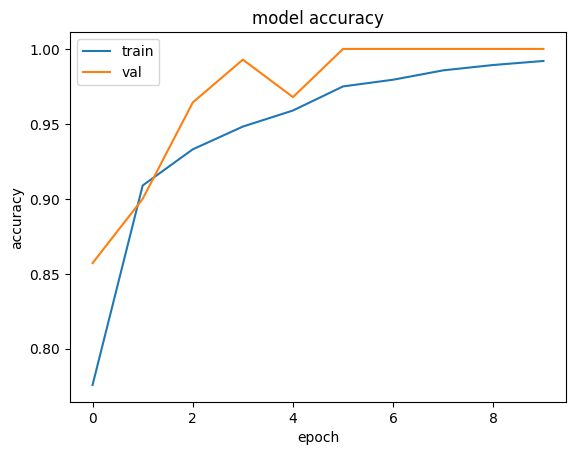

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

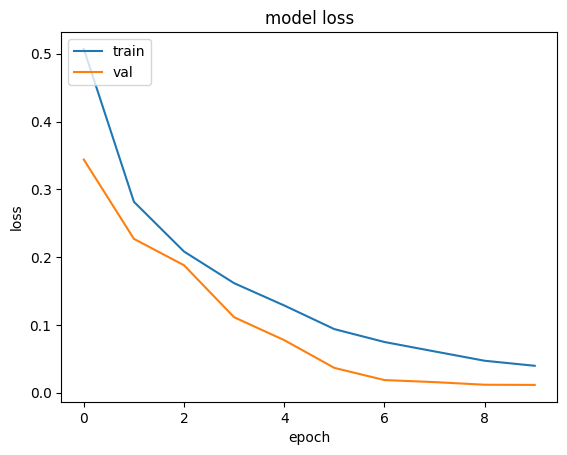

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/Deep Learning/save_model/Rqanet_{}.h5".format(fold))

In [ ]:
loaded_model.evaluate(X_test,y_test)

9/9 [==============================] - 2s 121ms/step - loss: 0.0364 - accuracy: 1.0000


[0.036449745297431946, 1.0]

In [ ]:
pre = loaded_model.predict(X_test)

9/9 [==============================] - 0s 23ms/step


In [ ]:
pre.shape

(280, 1)

In [ ]:
pre = pre.round()

In [ ]:
pre = pre.ravel()

https://datascience.stackexchange.com/questions/111576/how-to-add-the-luong-attention-mechanism-into-cnn

In [ ]:
from sklearn.metrics import classification_report
target_names = ["patient","normal"]
print(classification_report(y_test, pre, target_names=target_names))

              precision    recall  f1-score   support

     patient       1.00      1.00      1.00       140
      normal       1.00      1.00      1.00       140

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [ ]:
from sklearn.metrics import precision_score,recall_score, f1_score
print("precision_score", precision_score(y_test, pre))
print("recall_score", recall_score(y_test, pre))
print("f1-score ", f1_score(y_test, pre))

precision_score 1.0
recall_score 1.0
f1-score  1.0


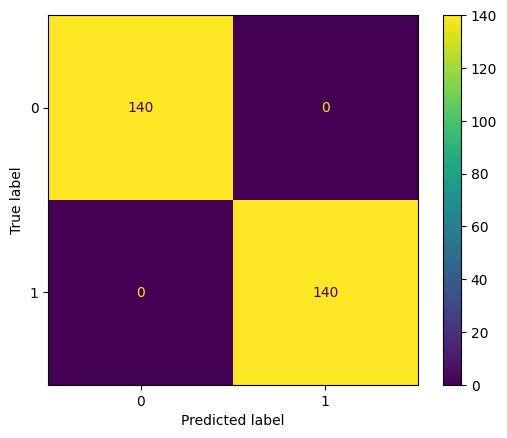

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pre)

In [ ]:
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
sensitivity = sensitivity_score(y_test, pre)
specificity = specificity_score(y_test, pre)
print("sensitivity =",sensitivity)
print("specificity =",specificity)

sensitivity = 1.0
specificity = 1.0
